# Dataset Creation

This notebook assumes you *already* have the following:

1. A LabelBox project with annotations completed: the project ID is typically stored in the config file
2. A GCP bucket to which you have write access, where the annotations will be exported to
3. A project config file that chooses either 2-class, 3-class or some other classification scheme (ANNO_CONFIG)


The outcomes will be:
A. Annotations for each image in the project will be exported to the GCP bucket
B. A json file will be created that maps the image names to the annotations, and all other relevant features of every observation and stored in the /dataset folder



In [1]:
import os, sys
sys.path.insert(0, os.path.abspath('..'))

%load_ext autoreload
%autoreload 2

In [2]:
from google.cloud import storage
from labelbox import Client as LabelboxClient

from utils import gcp_utils
from utils.data_management import get_annotation_path
from utils.labelbox_utils import get_annotation_objects_from_data_row_export, get_geojson_fc_from_annotation_objects, get_confidence_geojson_fc_from_annotation_objects
import geopandas as gpd

/home/ando/.conda/envs/rv_timm0412/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
# Load environment variables from .env.
# Alternatively, manually set environment variables.

from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from project_config import LABELBOX_PROJECT_ID, GCP_PROJECT_NAME, ANNO_CONFIG
LABELBOX_API_KEY = os.getenv('LABELBOX_API_KEY')

gcp_client = storage.Client(project=GCP_PROJECT_NAME)
labelbox_client = LabelboxClient(api_key=LABELBOX_API_KEY)

project = labelbox_client.get_project(LABELBOX_PROJECT_ID)

In [5]:
export_params = {"project_details": True}
export = project.export_v2(params=export_params)

export.wait_till_done()
if export.errors:
  print("Errors:")
  print(export.errors)
else:
  export_full_project = export.result
  print(f"Finished without errors. Total export contains {len(export_full_project)} data rows.")
  print(len(export_full_project))

Finished without errors. Total export contains 100 data rows.
100


# Process the annotations from Labelbox and export them to GCP storage



In [6]:
# from project_config import is_validation, is_training
from utils.data_management import generate_observation_pointer
from dataclasses import dataclass, asdict
import json, random


annotation_json_list = []
geojson_feature_collection_list = []

for data_row_export in export_full_project:
    global_key_data_row = data_row_export['data_row']['global_key']

    workflow_status = data_row_export['projects'][LABELBOX_PROJECT_ID]['project_details']['workflow_status']
    task_name = data_row_export['projects'][LABELBOX_PROJECT_ID]['project_details']["task_name"]
    # We filter depending on workflow_status
    if workflow_status in ["IN_REWORK", "TO_LABEL"] or "review" in workflow_status or "ignore" in workflow_status or task_name == "Ignore":
        continue
    assert workflow_status == "DONE" #or workflow_status == "IN_REVIEW"
    
    print(f"Processing annotations for {global_key_data_row}")
    try:
        annotated_objects = get_annotation_objects_from_data_row_export(data_row_export)
    except Exception as e:
        print("Exception caught:", str(e))
        continue
    
    #use this for 2-class annotations (mine/not mine)
    # geojson_feature_collection = get_geojson_fc_from_annotation_objects(annotated_objects)
    # use this for 3-class annotations (high conf/low conf/no mine)
    geojson_feature_collection = get_confidence_geojson_fc_from_annotation_objects(annotated_objects)
    annotation_destination_path = get_annotation_path(global_key_data_row, postfix=ANNO_CONFIG.postfix)
 
    observation_pointer = generate_observation_pointer(annotation_destination_path, global_key_data_row, cluster_id=-99)
    
    # #convert to dict
    obs_dict = asdict(observation_pointer)
    annotation_json_list.append(obs_dict)

    # #Upload annotations geojsons to GCP folders
    gcp_utils.upload_json(gcp_client, geojson_feature_collection, annotation_destination_path)


Processing annotations for Kathajodi_Cuttack_85-85_20-44_2022-05-01_rgb_median
Processing annotations for Tawa_Hoshangabad_77-80_22-74_2022-04-01_rgb_median
Processing annotations for Sone_Rohtas_84-21_24-91_2022-02-01_rgb_median
Processing annotations for Sone_Rohtas_84-21_24-91_2022-05-01_rgb_median
Processing annotations for Bhargavi_Khordha_85-88_20-26_2018-12-01_rgb_median
Processing annotations for Bhargavi_Khordha_85-88_20-26_2019-05-01_rgb_median
Processing annotations for Ganges_Patna_85-23_25-62_2022-05-01_rgb_median
Processing annotations for Ganges_Patna_85-1_25-66_2020-04-01_rgb_median
Processing annotations for Ganges_Patna_85-1_25-66_2019-11-01_rgb_median
Processing annotations for Damodar_PurbaBardhaman_87-73_23-24_2022-11-01_rgb_median
Processing annotations for Damodar_PurbaBardhaman_87-73_23-24_2023-04-01_rgb_median
Processing annotations for Mayurakshi_Birbhum_87-66_23-61_2023-05-01_rgb_median
Processing annotations for Balason_Darjeeling_88-32_26-75_2022-01-01_rgb_

# Generate the spatial clusters

These cluster_ids can be used for spatially based holdout splits.

Number of clusters: 12 / Number of unassigned points : 1


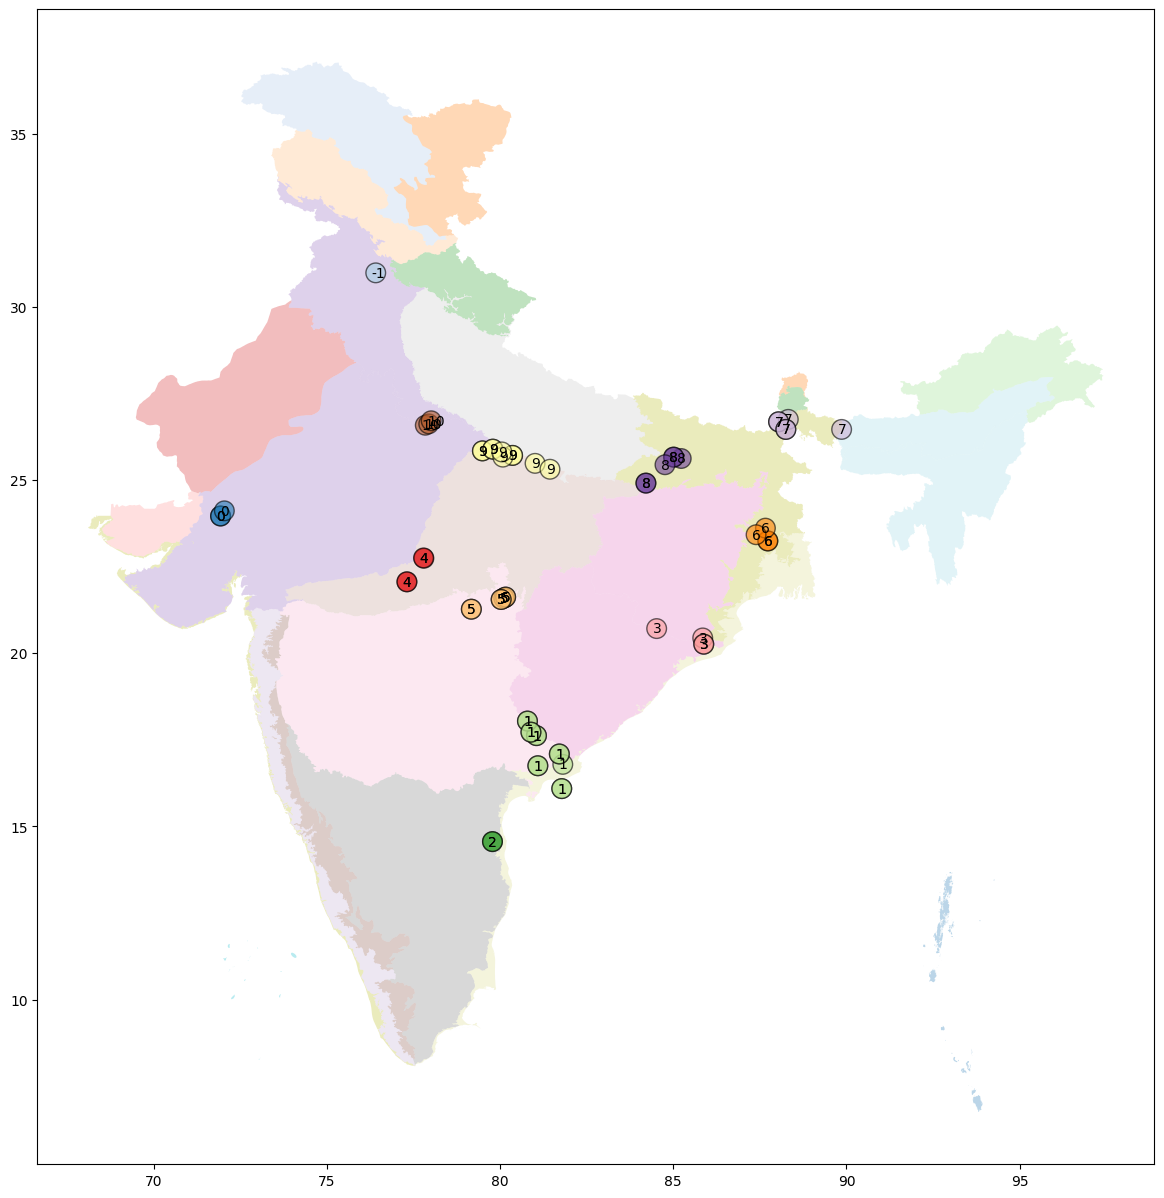

In [7]:
from utils.river_utils import cluster_observations, visualize_clusters

india_bio = gpd.read_file("/data/sand_mining/shapefiles/lyr_76_india_biogeographic.shp")
india_bio = india_bio.set_crs(4326, allow_override=True)
india_bio = [india_bio[['biogeoprov', 'geometry']]] # also turn it into a list

gdf = gpd.GeoDataFrame(annotation_json_list, geometry=gpd.points_from_xy([entry['longitude'] for entry in annotation_json_list], [entry['latitude'] for entry in annotation_json_list]))
gdf = cluster_observations(gdf, min_cluster_size=2, maximum_cluster_radius_km=100, max_cluster_size=5)
visualize_clusters(gdf, background_gdfs=india_bio) 


Update the dataset json with the cluster_id

In [8]:
import numpy as np
for i, entry in enumerate(annotation_json_list):
    annotation_json_list[i]['cluster_id'] = int(gdf.iloc[i]['cluster_id'])

cluster_ids = np.unique([anno["cluster_id"] for anno in annotation_json_list])
cluster_ids


array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

If there is a cluster_id == -1, then assign it a new cluster_id

In [9]:
#check if cluster_ids contains -1
if -1 in cluster_ids:
    print("Cluster ID -1 found. Assigning it to a new cluster.")
    new_cluster_id = np.max(cluster_ids) + 1
    for i, entry in enumerate(annotation_json_list):
        if entry['cluster_id'] == -1:
            annotation_json_list[i]['cluster_id'] = int(new_cluster_id)
            new_cluster_id += 1

np.unique([anno["cluster_id"] for anno in annotation_json_list], return_counts=True)


Cluster ID -1 found. Assigning it to a new cluster.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 array([ 3, 13,  2,  4,  4,  8,  4,  6,  6, 10,  3,  1]))

In [10]:
# Generate random validation cluster
random.seed(42)


cluster_ids = [annotation_json_list[i]['cluster_id'] for i in range(len(annotation_json_list))]
val_cluster_id = np.unique(cluster_ids).max() + 1
for cid in np.unique(cluster_ids):
    scene_idx = [i for i in range(len(cluster_ids)) if cluster_ids[i] == cid]
    #only pick scenes with more than 1 annotation
    try:
        val_idx = random.sample(scene_idx, 2)[0] 
        annotation_json_list[val_idx]["cluster_id"] = int(val_cluster_id)
    except ValueError:
        print(f"Cluster {cid}/{scene_idx} has only one annotation. Skipping.")
        continue

    # val_idx = random.sample(scene_idx, 1)[0]
    

np.unique([anno["cluster_id"] for anno in annotation_json_list], return_counts=True)

Cluster 11/[57] has only one annotation. Skipping.


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([ 2, 12,  1,  3,  3,  7,  3,  5,  5,  9,  2,  1, 11]))

In [11]:
def is_valid_json(json_string):
    try:
        json.loads(json_string)
        return True
    except json.JSONDecodeError:
        return False

is_valid_json(json.dumps(annotation_json_list))

True

## Save the dataset locally

In [12]:
#get today's date
from datetime import date
today = date.today().strftime("%Y-%m-%d")

filename = "dataset_{version}.json".format(version="v0.3.2-sr-seed42") #, date=today)
# get the current working directory
root_dir = os.getcwd()

# define the path to the new directory
dataset_dir = os.path.join(root_dir, '../dataset')

# create the directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

filename = os.path.join(dataset_dir, filename)

print(f"Saving dataset to {filename}")

# Save the dataset geojson
with open(filename, 'w') as f:
    json.dump(annotation_json_list, f, indent=4)


Saving dataset to /home/ando/sandmining-watch/label/../dataset/dataset_v0.3.2-sr-seed42.json


## Deleting annotations in GCP

In [ ]:
# CAREFUL
# Use with caution

# The following deletes all files in our GCP bucket with a _annotations.geojson file ending

"""
from project_config import BUCKET_NAME

bucket = gcp_client.get_bucket(BUCKET_NAME)
for blob in bucket.list_blobs():
    if blob.name.endswith("_annotations.geojson"):
        print(f"Deleting {blob} .. ")
        blob.delete()
"""